_Version log: Optimisation using Principle Component Analysis._

In [2]:
import sys, warnings, os
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, linalg as spla
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [3]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    mean = np.nanmean(samples) # LASSO IGNORES THE MEAN. lasso automatically normalises the samples such that they have a mean of 0. It therefore, cannot recover the zero frequency.

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward") +mean

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [4]:
training_dataset = 1

training_directory = "data\\training_set{0:}\\".format(training_dataset)
training_file_paths = [os.path.join(training_directory, file_name) for file_name in os.listdir(training_directory)]

training_data = np.array([np.genfromtxt(file_path, delimiter=",", filling_values= np.nan) for file_path in training_file_paths])

training_data = np.rollaxis(training_data, -1, 0) # move the last axis to the front
training_interferograms, training_uncertainty = training_data # now we can seperate the interferograms from the uncertainties. :)

training_interferograms.shape

(900, 200)

In [5]:
interferogram_to_test = 20
number_of_pca_components = 200

pca = PCA(n_components= number_of_pca_components)
pca.fit(training_interferograms) # is it possible to weight the datapoints using the uncertainty?

relitive_importance = pca.explained_variance_ratio_ #The most important component is first.
basis_transform = pca.components_ # components in the original basis.

sparse_interferograms = pca.transform(training_interferograms) #transform the interferograms into the sparse basis

# Reconstruct original data
recovered_interferogram = pca.inverse_transform(sparse_interferograms[interferogram_to_test])
recovered_interferogram2 = np.matmul(sparse_interferograms[interferogram_to_test], basis_transform) + pca.mean_ # like lasso, pca also normalises the data so the mean is more difficult to recover.

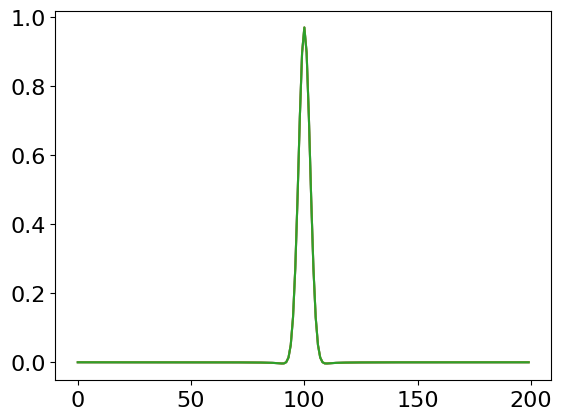

In [6]:
test_interferogram = training_interferograms[interferogram_to_test]

plt.plot(test_interferogram)
plt.plot(recovered_interferogram)
plt.plot(recovered_interferogram2)

plt.show()

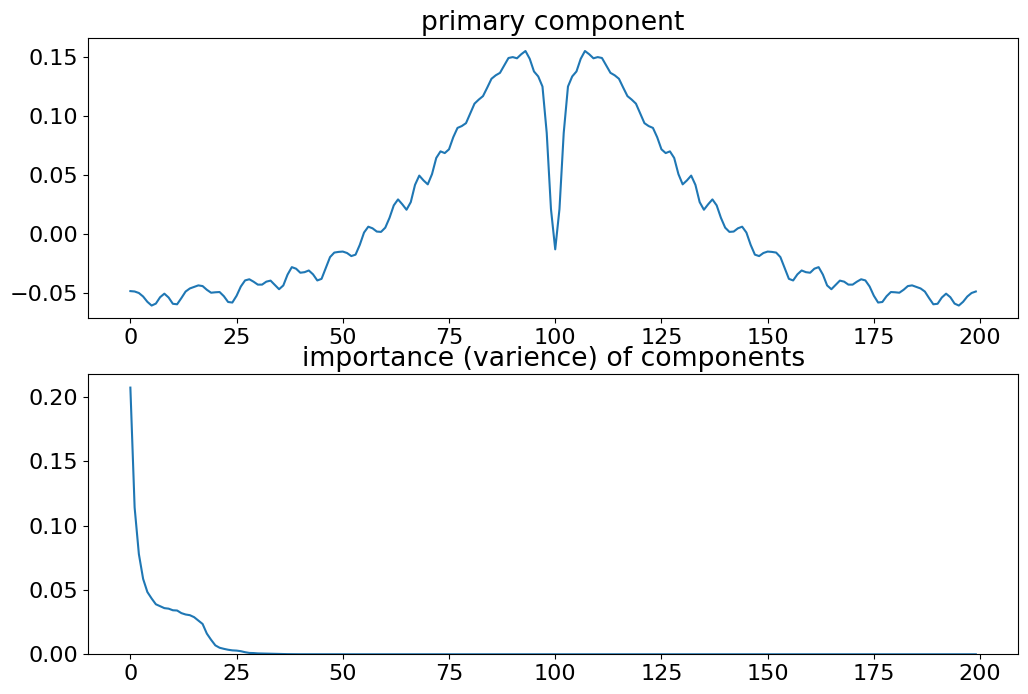

In [7]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(basis_transform[0])
axs[0].set(title= "primary component")

axs[1].plot(relitive_importance)
axs[1].set(ylim= (0, None), title= "importance (varience) of components")

plt.show()

In [8]:
# Compute QR factorization with column pivoting
Q, R, permutation_matrix = spla.qr(basis_transform, pivoting= True)

# P is the permutation matrix
print("Permutation Matrix (P):")
print(permutation_matrix)


Permutation Matrix (P):
[100   3   6  19  23  35  63  93 107 131 149 159  29 126 154 168  30 172
  37  81 125  80 108 118  26   4 193  60  61 122  36  71  75 128  76 102
 150  58 114 155 185 191  51 119  73  24 197 117 186  52  90 162  53  40
   2  34 199  27  44  94  20  13 135  66  87 124  11 153  28 158 176 179
  95 109  54 174   1  92  97   5   8  12 144 148  69  17  45  64  98  99
 111 129  85 175 180 189 190 194  79 104 110 120  65 127 132 134 136 137
 139 146  10  16 151  84 161  42 167 173 184 187  41  86 103 138 140 142
 145  50 152 160  38  15 170  70  31  46 123  83  67 113 164 133 177 188
  96 196  62  56   0  14 156 115  89 121  18  39 157  74 112 165   9  33
 141  57  49 192  78  77  47 178 105 181 183  25  88  43 101  55 106 195
  68 182 116  48  72  22 163 169 130  21 198 171   7 166 143  59  91 147
  82  32]


In [9]:
number_of_detectors = 30
regularization_coeffient = 1e-4

detectors = permutation_matrix[:number_of_detectors]

In [10]:
samples = test_interferogram[detectors]
measurement_matrix = basis_transform[:,detectors]
mean = np.mean(samples)

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(basis_transform.T, lasso.coef_) +mean

In [11]:
result2 = compressed_sensing(samples, detectors, 200, regularization_coeffient)

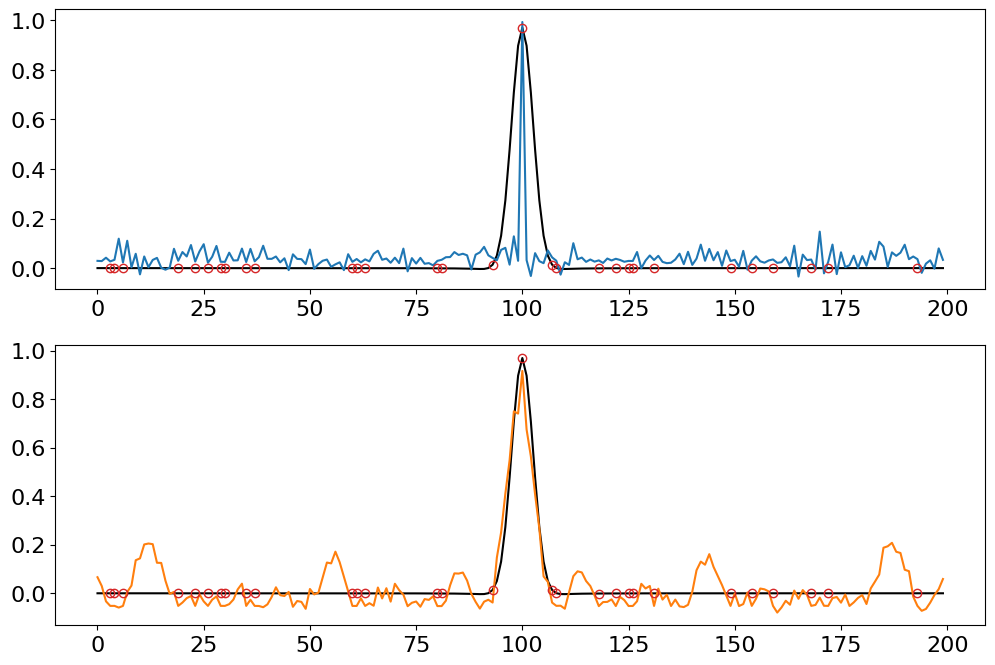

In [12]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

plt.show()